In [63]:
## In this notebook, I have explored this phenomenon using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates of left-handedness over time, refuting the claim of early death for left-handers. This notebook uses pandas and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed.

In [64]:
## This notebook uses two datasets: death distribution data for the United States from the year 1999 (source website here) and rates of left-handedness digitized from a figure in this 1992 paper by Gilbert and Wysocki.

In [43]:
## Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

data_url = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
left_handed = pd.read_csv(data_url)

In [44]:
print(left_handed.head())

   Age       Male     Female
0   10  12.717558  12.198041
1   11  15.318830  11.144804
2   12  14.808281  11.549240
3   13  13.793744  11.276442
4   14  15.156304  11.572906


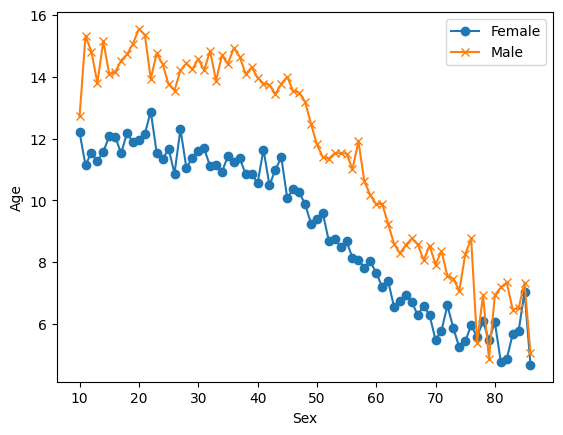

In [45]:
## Plotting left-handedness of males and females vs age
%matplotlib inline
fig,ax = plt.subplots()
ax.plot('Age','Female',data=left_handed, marker='o')
ax.plot('Age','Male',data=left_handed, marker='x')
ax.set_xlabel('Sex')
ax.set_ylabel('Age')
ax.legend()

Rates of left-handedness

In [46]:
left_handed["Birth_year"] = 1986-left_handed["Age"] # As the study was done in 1986

left_handed["Mean_Left_Handed"] = left_handed[["Female","Male"]].mean(axis=1)

Text(0, 0.5, 'Birth_year')

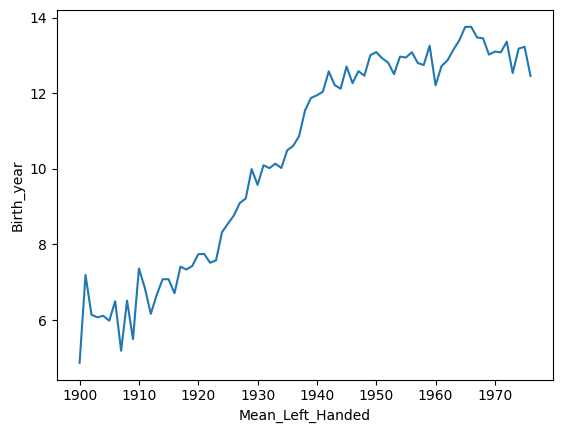

In [47]:
# plotting the graph
fig,ax = plt.subplots()
ax.plot("Birth_year","Mean_Left_Handed", data=left_handed)
ax.set_xlabel("Mean_Left_Handed")
ax.set_ylabel("Birth_year")

Applying Bayes' Rule

In [48]:
import numpy as np

In [49]:
## creating a function for P(H|A)
def P_lh_given_age(ages_of_death, study_year=1990):
      """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
      early_1990 = left_handed['Mean_Left_Handed'][-10:].mean()
      late_1990 = left_handed['Mean_Left_Handed'][:10].mean()
      middle_rates = left_handed.loc[left_handed['Birth_year'].isin(study_year - ages_of_death)]['Mean_Left_Handed']
      youngest_age = study_year-1986+10
      oldest_age = study_year-1986+86

      P_return = np.zeros(ages_of_death.shape)
      P_return[ages_of_death>oldest_age] = early_1990/100
      P_return[ages_of_death<youngest_age] = late_1990/100
      P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates/100


      return P_return





In [50]:
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

death_data = pd.read_csv(data_url_2, sep = '\t', skiprows=[1])

In [51]:
death_ata = death_data.dropna(subset = ["Both Sexes"])


Text(0, 0.5, 'Both Sexes')

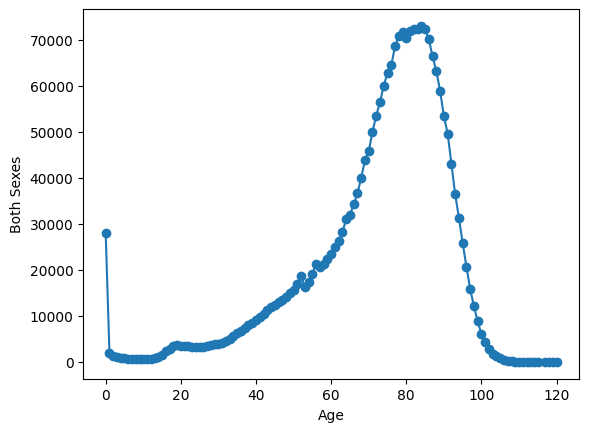

In [52]:
fig, ax = plt.subplots()
ax.plot('Age','Both Sexes', data=death_data,marker='o')
ax.set_xlabel('Age')
ax.set_ylabel('Both Sexes')

In [53]:
def P_lh(death_data, study_year = 1990):
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """

    p_list = death_data['Both Sexes']*P_lh_given_age(death_data['Age'], study_year)

    p = np.sum(p_list) 
    return p/np.sum(death_data['Both Sexes'])


print(P_lh(death_data))

0.0776638761535064


Dying while left handed

In [54]:
def P_A_given_lh(ages_of_death, death_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_data["Both Sexes"].loc[ages_of_death] / np.sum(death_data["Both Sexes"])
    P_left = P_lh(death_data, study_year)
    P_lh_A = P_lh_given_age(ages_of_death, study_year)
    return P_lh_A * P_A / P_left

dying while right handed

In [55]:
def P_A_given_rh(ages_of_death, death_data, study_year=1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_data["Both Sexes"].loc[ages_of_death] / np.sum(death_data["Both Sexes"])
    P_right = 1 - P_lh(death_data, study_year)  # assuming P_right is 1 - P_left
    P_rh_A = 1 - P_lh_given_age(ages_of_death, study_year)
    return P_rh_A * P_A / P_right

In [56]:
ages = np.arange(6, 115, 1)
ages.shape

(109,)

In [57]:
left_handed_probability = P_A_given_lh(ages, death_data)
right_handed_probability = P_A_given_rh(ages, death_data)

Text(0, 0.5, 'Probability of being age A at death')

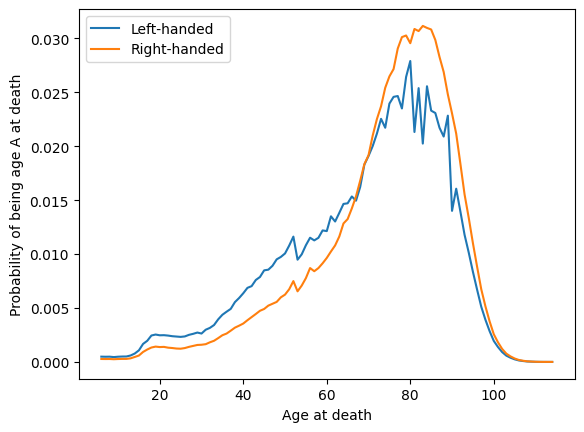

In [58]:
fix, ax = plt.subplots()
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel("Probability of being age A at death")

In [59]:
avg_lh_age = np.nansum(ages*np.array(left_handed_probability))
avg_rh_age = np.nansum(ages*np.array(right_handed_probability))

In [60]:
print("Average age of left handed people:" + str(avg_lh_age))
print("Average age of right handed people:" + str(avg_rh_age))

Average age of left handed people:67.24503662801025
Average age of right handed people:72.7917193652648


In [61]:
print("Difference in ages:" + str(round(avg_lh_age-avg_rh_age,1)))

Difference in ages:-5.5


In [65]:
## We got a pretty big age gap between left-handed and right-handed people purely as a result of the changing rates of left-handedness in the population, which is good news for left-handers: